In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.4 MB/s eta 0:00:00


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

def oracle_constant(qc, ancilla, value=0):
    """Constant oracle: f(x)=0 or f(x)=1"""
    if value == 1:
        qc.x(ancilla)


def oracle_balanced_parity(qc, inputs, ancilla):
    """Balanced oracle (parity): f(x) = x0 XOR x1 XOR ... XOR xn"""
    for q in inputs:
        qc.cx(q, ancilla)

In [3]:
#Task 1: NEW balanced oracles

def oracle_balanced_linear_mask(qc, inputs, ancilla, a_mask:int=0b1, b:int=0):
    if a_mask == 0:
        raise ValueError("a_mask must be non-zero for a balanced function.")
    for i, q in enumerate(inputs):
        if (a_mask >> i) & 1:
            qc.cx(q, ancilla)
    if b == 1:
        qc.x(ancilla)


def oracle_balanced_non_linear(qc, inputs, ancilla):
    if len(inputs) < 3:
        raise ValueError("oracle_balanced_non_linear needs at least 3 input qubits.")
    x0, x1, x2 = inputs[0], inputs[1], inputs[2]
    # Add (x1 AND x2) into ancilla
    qc.ccx(x1, x2, ancilla)
    # XOR x0
    qc.cx(x0, ancilla)
    # Uncompute (x1 AND x2) so the oracle remains a clean unitary
    qc.ccx(x1, x2, ancilla)


In [4]:
# DEUTSCH–JOZSA CIRCUIT
def deutsch_jozsa_circuit(n, oracle_func, *oracle_args, **oracle_kwargs):
    """
    n: number of input qubits
    oracle_func: oracle function to modify the circuit
    oracle_args/kwargs: passed to oracle_func
    """
    qreg = QuantumRegister(n + 1, "q")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qreg, creg)

    inputs = list(range(n))
    ancilla = n

    # Step 1: Initialize |0...0>|1>
    qc.x(ancilla)

    # Step 2: Apply Hadamard to all qubits
    qc.h(qreg)

    # Step 3: Oracle (in-place on the same circuit)
    oracle_func(qc, *oracle_args, **oracle_kwargs)

    # Step 4: Apply Hadamard to input qubits
    for q in inputs:
        qc.h(q)

    # Step 5: Measure only input qubits
    qc.measure(inputs, creg)

    return qc

In [5]:
# ---------- EXECUTION ----------
def run_dj(qc, title=None, backend=None, shots=1024, show_hist=True):
    """
    Run Deutsch–Jozsa circuit on given backend (default: AerSimulator).
    Prints counts and the decision.
    """
    if backend is None:
        backend = AerSimulator()
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if title:
        print(f"\n--- {title} ---")
    print("Measurement counts:", counts)
    if show_hist:
        plot_histogram(counts)
        plt.title(title or "Results")
        plt.show()

    n = qc.num_clbits
    if counts.get("0" * n, 0) == shots:
        print("✅ Function is CONSTANT")
    else:
        print("✅ Function is BALANCED")

    # Also show circuit depth after transpile (Task 2)
    print("Transpiled circuit depth:", tqc.depth())

    return counts



In [6]:
# Task 3: Noisy Simulation
def make_simple_noise_model():
    from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

    noise_model = NoiseModel()

    # Depolarizing error rates
    p1 = 0.001  # 1-qubit
    p2 = 0.01   # 2-qubit

    # Apply noise to 1-qubit gates
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1),
                                            ['x', 'h', 'sx'])

    # Apply noise to 2-qubit gates (do NOT include ccx!)
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2),
                                            ['cx'])

    # Readout error
    pr = 0.02
    readout = ReadoutError([[1 - pr, pr], [pr, 1 - pr]])
    noise_model.add_all_qubit_readout_error(readout)

    return noise_model


In [11]:
# Task 4: Run on IBM Quantum (safe error-free version)

def run_on_ibm(qc, shots=1024):
    """
    Safely runs on IBM Quantum hardware if access exists.
    Will NOT throw any error even if token is missing or backend is unavailable.
    """
    try:
        from qiskit_ibm_runtime import QiskitRuntimeService
    except ImportError:
        print("❌ qiskit_ibm_runtime not installed. Skipping IBM run.")
        return None

    try:
        # try loading saved IBM account
        service = QiskitRuntimeService()

        # try to pick an available real backend
        backends = service.backends(simulator=False, operational=True)
        if not backends:
            print("⚠️ No real IBM Quantum device available.")
            return None

        backend = service.least_busy(simulator=False, operational=True)
        print(f"🖥️  Selected backend: {backend.name}")

        # transpile + run
        tqc = transpile(qc, backend, optimization_level=3)
        print("🚀 Submitting job to IBM Quantum hardware...")
        job = backend.run(tqc, shots=shots)

        print(f"📡 Job ID: {job.job_id()}  (waiting for result...)")
        result = job.result()
        counts = result.get_counts()

        print("✅ IBM Quantum hardware counts:", counts)
        return counts

    except Exception as exc:
        print("⚠️ Could not run on IBM Quantum hardware.")
        print(f"Reason: {exc}")
        print("💡 Tip: Did you save your token?")
        print("    QiskitRuntimeService.save_account(channel='ibm_quantum', token='YOUR_TOKEN')")
        return None


In [12]:
# Task 5: Oracle unitary / analysis
def oracle_unitary(oracle_builder, n, *args, **kwargs):
    """
    Builds a stand-alone oracle unitary on n input + 1 ancilla (no H, no measure),
    returns the Operator (unitary matrix) and prints a small textual decomposition.
    NOTE: The matrix size is 2^(n+1) x 2^(n+1); keep n small (<=4) if you want to print it.
    """
    qreg = QuantumRegister(n + 1, "q")
    qc_oracle = QuantumCircuit(qreg, name="U_f")
    inputs = list(range(n))
    ancilla = n
    oracle_builder(qc_oracle, inputs, ancilla, *args, **kwargs)

    # Print gate decomposition (readable)
    print("\nOracle gate decomposition:")
    print(qc_oracle.to_gate().definition)

    # Unitary matrix
    U = Operator(qc_oracle)
    sz = U.data.shape[0]
    print(f"Unitary size: {sz} x {sz}")
    return U



==== n = 2 =====

--- Constant f(x)=0 (n=2) ---
Measurement counts: {'00': 1024}


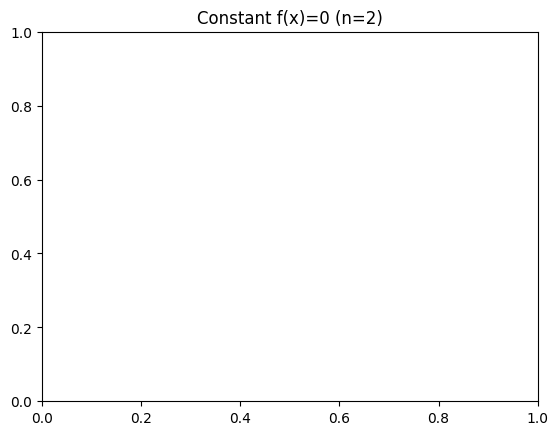

✅ Function is CONSTANT
Transpiled circuit depth: 1

--- Balanced (parity) (n=2) ---
Measurement counts: {'11': 1024}


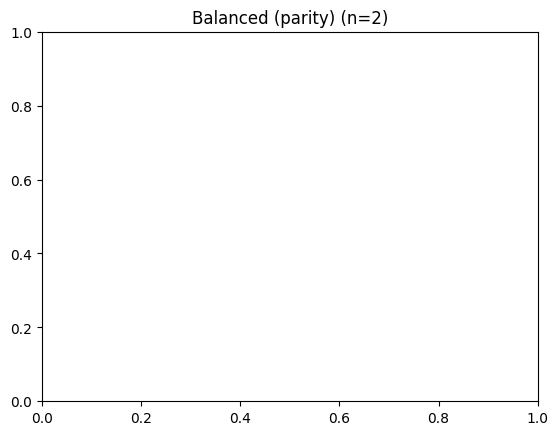

✅ Function is BALANCED
Transpiled circuit depth: 5

--- Balanced linear mask a=0b1, b=1 (n=2) ---
Measurement counts: {'01': 1024}


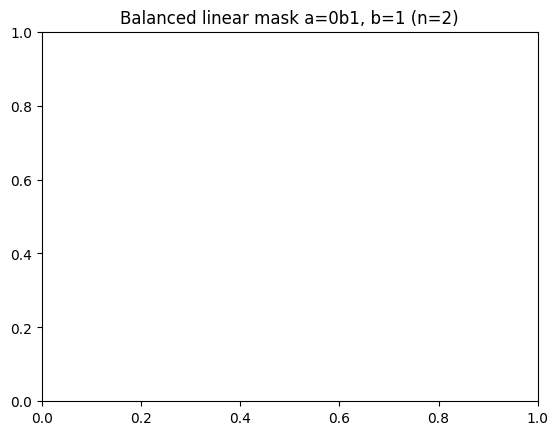

✅ Function is BALANCED
Transpiled circuit depth: 4

==== Task 4: IBM Quantum Execution =======

--- Attempting run on IBM Quantum hardware (n=2) ---
⚠️ Could not run on IBM Quantum hardware.
Reason: "Unable to find account. Please make sure an account with the channel name 'ibm_quantum_platform' is saved."
💡 Tip: Did you save your token?
    QiskitRuntimeService.save_account(channel='ibm_quantum', token='YOUR_TOKEN')
⚠️ IBM run did not execute — check token / internet.

==== n = 3 =====

--- Constant f(x)=0 (n=3) ---
Measurement counts: {'000': 1024}


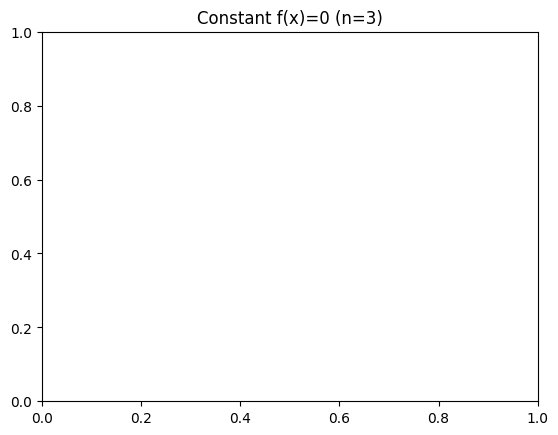

✅ Function is CONSTANT
Transpiled circuit depth: 1

--- Balanced (parity) (n=3) ---
Measurement counts: {'111': 1024}


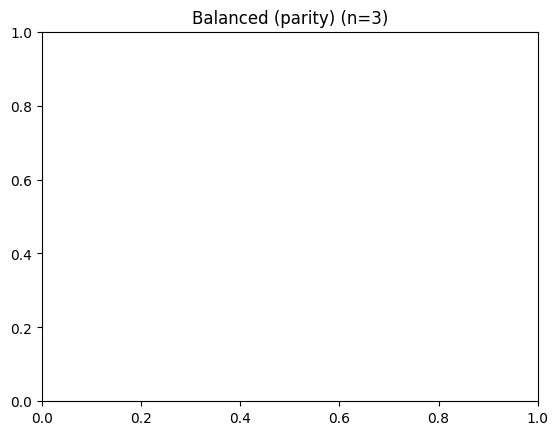

✅ Function is BALANCED
Transpiled circuit depth: 6

--- Balanced linear mask a=0b101, b=1 (n=3) ---
Measurement counts: {'101': 1024}


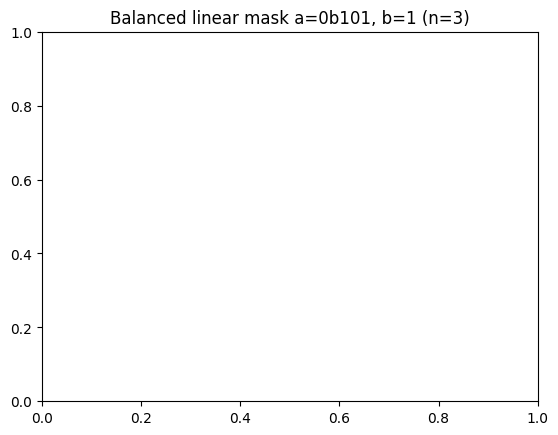

✅ Function is BALANCED
Transpiled circuit depth: 5

--- Balanced non-linear (x0 XOR (x1 AND x2)) (n=3) ---
Measurement counts: {'001': 1024}


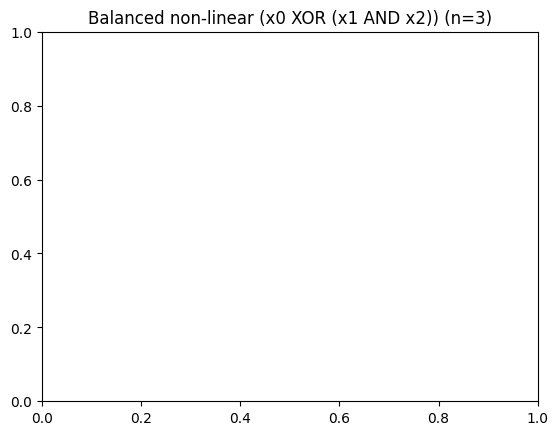

✅ Function is BALANCED
Transpiled circuit depth: 6

--- Noisy simulation (n=3, linear mask) ---

--- Noisy DJ (n=3, linear mask) ---
Measurement counts: {'000': 3, '111': 19, '100': 25, '001': 25, '101': 952}


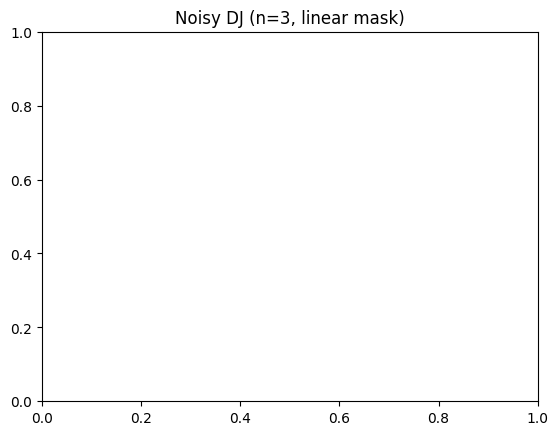

✅ Function is BALANCED
Transpiled circuit depth: 6

--- Ideal DJ (n=3, linear mask) ---
Measurement counts: {'101': 1024}
✅ Function is BALANCED
Transpiled circuit depth: 5
Ideal counts (n=3): {'101': 1024}

==== n = 4 =====

--- Constant f(x)=0 (n=4) ---
Measurement counts: {'0000': 1024}


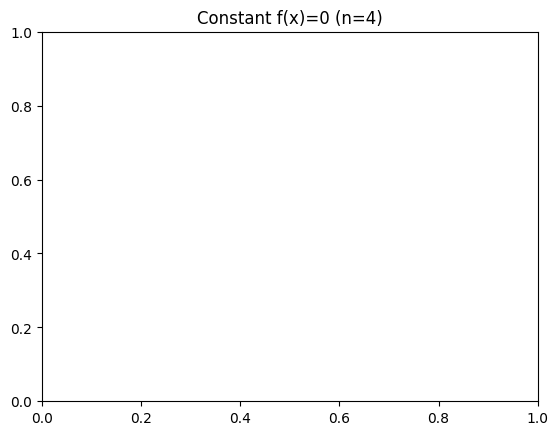

✅ Function is CONSTANT
Transpiled circuit depth: 1

--- Balanced (parity) (n=4) ---
Measurement counts: {'1111': 1024}


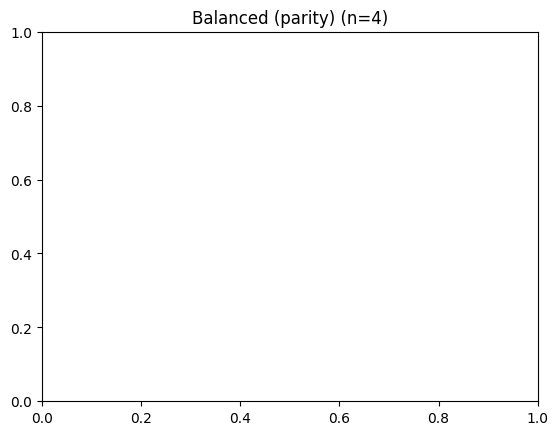

✅ Function is BALANCED
Transpiled circuit depth: 7

--- Balanced linear mask a=0b101, b=1 (n=4) ---
Measurement counts: {'0101': 1024}


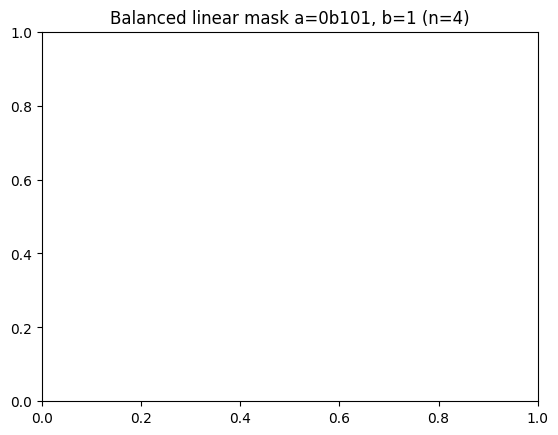

✅ Function is BALANCED
Transpiled circuit depth: 5

--- Balanced non-linear (x0 XOR (x1 AND x2)) (n=4) ---
Measurement counts: {'0001': 1024}


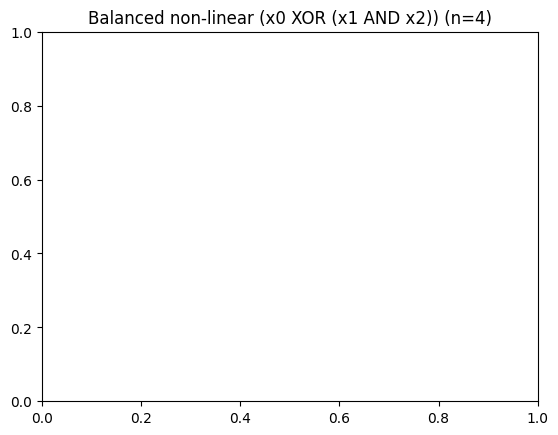

✅ Function is BALANCED
Transpiled circuit depth: 6

==== n = 5 =====

--- Constant f(x)=0 (n=5) ---
Measurement counts: {'00000': 1024}


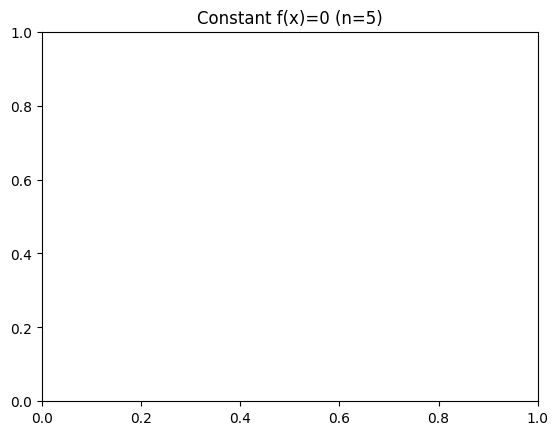

✅ Function is CONSTANT
Transpiled circuit depth: 1

--- Balanced (parity) (n=5) ---
Measurement counts: {'11111': 1024}


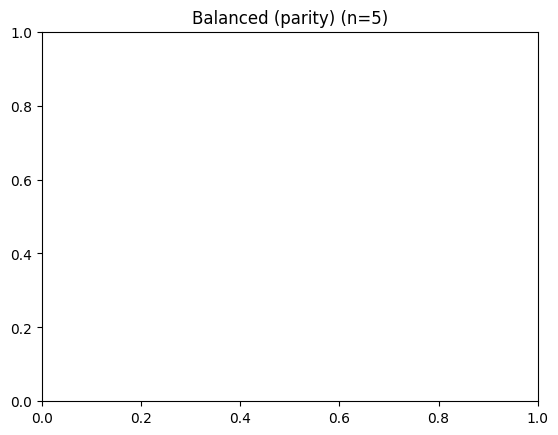

✅ Function is BALANCED
Transpiled circuit depth: 8

--- Balanced linear mask a=0b101, b=1 (n=5) ---
Measurement counts: {'00101': 1024}


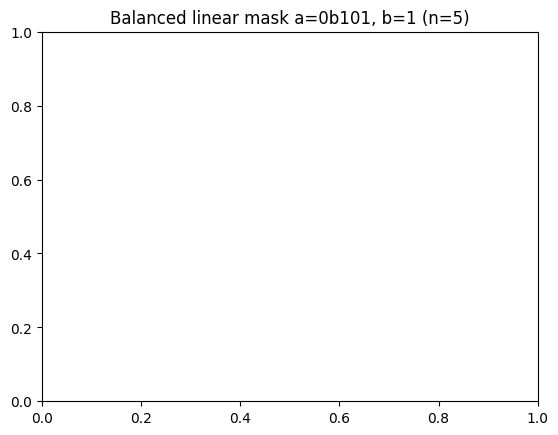

✅ Function is BALANCED
Transpiled circuit depth: 5

--- Balanced non-linear (x0 XOR (x1 AND x2)) (n=5) ---
Measurement counts: {'00001': 1024}


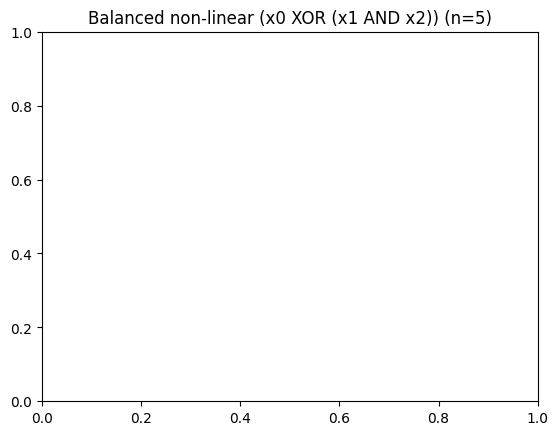

✅ Function is BALANCED
Transpiled circuit depth: 6

========= Task 5: Oracle unitary (n=3) =========

Oracle gate decomposition:
                    
q_0: ──■────────────
       │            
q_1: ──┼────────────
       │            
q_2: ──┼────■───────
     ┌─┴─┐┌─┴─┐┌───┐
q_3: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘
Unitary size: 16 x 16

  -Each CX from input qubit i to ancilla contributes x_i to f(x) (mod 2)
  -Mask bit = 1 → include that input in XOR
  -b = 1 adds constant term
  -Matches |x>|y> → |x>|y ⊕ f(x)> for Deutsch–Jozsa Oracle
    


In [15]:
# MAIN
if __name__ == "__main__":
    for n in [2, 3, 4, 5]:
        print(f"\n==== n = {n} =====")

        # CONSTANT ORACLE
        qc_const0 = deutsch_jozsa_circuit(n, oracle_constant, n, 0)
        run_dj(qc_const0, title=f"Constant f(x)=0 (n={n})")

        # PARITY ORACLE (Balanced)
        inputs = list(range(n))
        qc_parity = deutsch_jozsa_circuit(n, oracle_balanced_parity, inputs, n)
        run_dj(qc_parity, title=f"Balanced (parity) (n={n})")

        # Balanced Linear Mask Oracle
        mask = 0b101 if n >= 3 else 0b01
        qc_lin = deutsch_jozsa_circuit(
            n, oracle_balanced_linear_mask, inputs, n, a_mask=mask, b=1
        )
        run_dj(qc_lin, title=f"Balanced linear mask a={bin(mask)}, b=1 (n={n})")

        # Balanced Non-Linear Oracle (n ≥ 3)
        if n >= 3:
            qc_nl = deutsch_jozsa_circuit(n, oracle_balanced_non_linear, inputs, n)
            run_dj(qc_nl, title=f"Balanced non-linear (x0 XOR (x1 AND x2)) (n={n})")

        # Task-3 Noisy Simulation (Only once at n = 3)
        if n == 3:
            noise_model = make_simple_noise_model()
            noisy_backend = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)
            print("\n--- Noisy simulation (n=3, linear mask) ---")
            run_dj(qc_lin, title="Noisy DJ (n=3, linear mask)", backend=noisy_backend)

            ideal_counts = run_dj(qc_lin, title="Ideal DJ (n=3, linear mask)", backend=AerSimulator(), show_hist=False)
            print("Ideal counts (n=3):", ideal_counts)

        # Task-4 IBM Real Hardware (Only at n = 2)
        if n == 2:
            print("\n==== Task 4: IBM Quantum Execution =======")
            print("\n--- Attempting run on IBM Quantum hardware (n=2) ---")

            counts_ibm = run_on_ibm(qc_lin)
            if counts_ibm is not None:
                print("\n✅ IBM Quantum Hardware Measurement Counts:")
                print(counts_ibm)

                plot_histogram(counts_ibm)
                plt.title("IBM Quantum Hardware Results (Deutsch–Jozsa)")
                plt.show()

                # DJ decision
                if "0"*n in counts_ibm and counts_ibm["0"*n] == max(counts_ibm.values()):
                    print("🟢 Result: Function is CONSTANT")
                else:
                    print("🟣 Result: Function is BALANCED")
            else:
                print("⚠️ IBM run did not execute — check token / internet.")

    # Task-5: Oracle Unitary
    n_small = 3
    print(f"\n========= Task 5: Oracle unitary (n={n_small}) =========")
    U = oracle_unitary(oracle_balanced_linear_mask, n_small, a_mask=0b101, b=1)

    print("""
  -Each CX from input qubit i to ancilla contributes x_i to f(x) (mod 2)
  -Mask bit = 1 → include that input in XOR
  -b = 1 adds constant term
  -Matches |x>|y> → |x>|y ⊕ f(x)> for Deutsch–Jozsa Oracle
    """)
